In [1]:
!pip install scikit-learn tqdm transformers torch --quiet


In [2]:
!pip install numpy==1.21.6 scipy==1.7.3 scikit-learn==1.1.3 scikit-multilearn==0.2.0 tqdm --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.3.3 requires numpy>=1.22.4; python_version < "3.11", but you have numpy 1.21.6 which is incompatible.


In [3]:
!pip install numpy --upgrade
!pip install scipy --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.2.6 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Attempting uninstall: scipy
    Found existing ins

In [4]:
import sys, os
os.system("pip uninstall -y scikit-learn numpy scipy scikit-multilearn")
os.system("pip install --no-cache-dir numpy==1.21.6 scipy==1.7.3")
os.system("pip install --no-cache-dir scikit-learn==1.1.3 scikit-multilearn==0.2.0 tqdm")
print("Installed. NOW RESTART THE KERNEL / RUNTIME (Colab: Runtime -> Restart runtime, Jupyter: Kernel -> Restart).")


Found existing installation: scikit-learn 1.1.3
Uninstalling scikit-learn-1.1.3:
  Successfully uninstalled scikit-learn-1.1.3
Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-multilearn 0.2.0
Uninstalling scikit-multilearn-0.2.0:
  Successfully uninstalled scikit-multilearn-0.2.0
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 78.5 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.3.3 requires numpy>=1.22.4; python_version < "3.11", but you have numpy 1.21.6 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 283.4 MB/s eta 0:00:00
Installed. NOW RESTART THE KERNEL / RUNTIME (Colab: Runtime -> Restart runtime, Jupyter: Kernel -> Restart).


In [1]:
import os
import numpy as np
import random
import time
from tqdm import tqdm

from scipy.sparse import vstack  # only for final train+val stacking if needed
from sklearn.metrics import f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors


In [2]:
import bz2
# Download and read LexGLUE ECtHR (B) raw text dataset
base = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel/"
files_b = {
    "train": "ecthr_b_lexglue_raw_texts_train.txt.bz2",
    "val":   "ecthr_b_lexglue_raw_texts_val.txt.bz2",
    "test":  "ecthr_b_lexglue_raw_texts_test.txt.bz2"
}

os.makedirs("data", exist_ok=True)

def download_if_missing(fname):
    dest = os.path.join("data", fname)
    if not os.path.exists(dest):
        url = base + fname
        print("Downloading:", url)
        urllib.request.urlretrieve(url, dest)
    return dest

def read_raw_txt_bz2(path):
    texts, labels = [], []
    with bz2.open(path, "rt", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if "\t" in line:
                labstr, txt = line.split("\t", 1)
            else:
                parts = line.split(maxsplit=1)
                if len(parts) < 2:
                    continue
                labstr, txt = parts
            labs = [l.strip() for l in labstr.split(",") if l.strip() != ""]
            labels.append(labs)
            texts.append(txt.replace("\n", " "))
    return texts, labels

# Download all files for ECtHR (B)
paths_b = {k: download_if_missing(v) for k, v in files_b.items()}

# Read them
train_texts_b, train_labels_b = read_raw_txt_bz2(paths_b["train"])
val_texts_b, val_labels_b     = read_raw_txt_bz2(paths_b["val"])
test_texts_b, test_labels_b   = read_raw_txt_bz2(paths_b["test"])
train_texts_b = train_texts_b[:4000]
train_labels_b = train_labels_b[:4000]

val_texts_b = val_texts_b[:500]
val_labels_b = val_labels_b[:500]

test_texts_b = test_texts_b[:500]
test_labels_b = test_labels_b[:500]


print(f"Train: {len(train_texts_b)}, Val: {len(val_texts_b)}, Test: {len(test_texts_b)}")


Train: 4000, Val: 500, Test: 500


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import numpy as np

# 1. Load LEGAL-BERT
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 2. Setup batching
def get_cls_embeddings(texts, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.pooler_output.detach().cpu().numpy()
            all_embeddings.append(cls_embeddings)
    return np.vstack(all_embeddings)  # Shape: (num_samples, 768)

# 3. Encode multi-label targets
mlb = MultiLabelBinarizer()
mlb.fit(train_labels_b + val_labels_b + test_labels_b)  # Fit on all splits

# 4. Prepare each split (Example: Train set)
print("Processing train set...")
train_embeddings = get_cls_embeddings(train_texts_b, batch_size=16)
train_targets = mlb.transform(train_labels_b)  # Shape: (num_samples, num_classes)

print("Processing validation set...")
val_embeddings = get_cls_embeddings(val_texts_b, batch_size=16)
val_targets = mlb.transform(val_labels_b)

print("Processing test set...")
test_embeddings = get_cls_embeddings(test_texts_b, batch_size=16)
test_targets = mlb.transform(test_labels_b)

print("Shapes:")
print("Train embeddings:", train_embeddings.shape)
print("Train targets:", train_targets.shape)
print("Val embeddings:", val_embeddings.shape)
print("Val targets:", val_targets.shape)
print("Test embeddings:", test_embeddings.shape)
print("Test targets:", test_targets.shape)

# Now you have (embeddings, targets) pairs for ML modeling!
# Example for torch/keras: X = train_embeddings, y = train_targets


Processing train set...


100%|██████████████████████████████████████████████████████████████████| 250/250 [00:23<00:00, 10.55it/s]


Processing validation set...


100%|████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.31it/s]


Processing test set...


100%|████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.33it/s]

Shapes:
Train embeddings: (4000, 768)
Train targets: (4000, 167)
Val embeddings: (500, 768)
Val targets: (500, 167)
Test embeddings: (500, 768)
Test targets: (500, 167)


In [4]:
def ContinousCrossover(posA, posB, gamma=0.4):
    alpha = np.random.uniform(-gamma, 1 + gamma, size=posA.shape)
    child1 = alpha * posA + (1 - alpha) * posB
    child2 = alpha * posB + (1 - alpha) * posA
    return child1, child2

def ContinousMutation(position, problem, sigma=0.1):
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    noise = np.random.normal(scale=sigma, size=position.shape)
    mutated = position + noise
    return np.clip(mutated, VarMin, VarMax)

def printingperiter(problem, it, gbest, namemethod, funcevals, curtrial, population=None):
    print(f"[{namemethod}] Iter {it} | Evals {funcevals} | Best cost {gbest['cost']:.5f}")


In [5]:
class CustomMLKNN:
    """
    Multi-label KNN classifier with optional distance weighting and Laplace smoothing.

    - Finds k nearest neighbors using sklearn.neighbors.NearestNeighbors.
    - Probability for each label (per test sample):
        probs = (sum_i w_i * y_i + s) / (sum_i w_i + 2*s)
      where w_i are neighbor weights (1 for uniform, 1/(dist+eps) for distance).
    - Handles k > n_train by using k_eff = min(k, n_train).
    - Works with dense numpy arrays.
    """

    def __init__(self, k=10, s=1.0, metric='cosine', weights='uniform', algorithm='auto', eps=1e-8):
        """
        Parameters
        ----------
        k : int
            Number of neighbors (will be clipped to number of training samples).
        s : float
            Laplace smoothing factor (>=0).
        metric : str
            Distance metric passed to sklearn.neighbors.NearestNeighbors.
        weights : {'uniform', 'distance'}
            Voting scheme. 'distance' uses 1/(dist + eps) weights.
        algorithm : str
            Algorithm for NearestNeighbors ('auto', 'brute', 'kd_tree', 'ball_tree').
        eps : float
            Small value to avoid division by zero when computing distance weights.
        """
        self.k = int(max(1, k))
        self.s = float(s)
        self.metric = metric
        self.weights = weights
        self.algorithm = algorithm
        self.eps = float(eps)

        self.nn = None
        self.X_train = None
        self.Y_train = None
        self.n_samples = 0
        self.n_labels = 0
        self.k_eff = None

    def fit(self, X, Y):
        import numpy as _np
        from sklearn.neighbors import NearestNeighbors

        X = _np.asarray(X)
        Y = _np.asarray(Y).astype(int)

        if X.ndim != 2:
            raise ValueError("X must be a 2D array (n_samples, n_features).")
        if Y.ndim != 2:
            raise ValueError("Y must be a 2D array (n_samples, n_labels).")
        if X.shape[0] != Y.shape[0]:
            raise ValueError("X and Y must have the same number of rows (samples).")

        self.X_train = X
        self.Y_train = Y
        self.n_samples, self.n_labels = self.Y_train.shape

        # effective k (can't be larger than number of training samples)
        self.k_eff = min(self.k, max(1, self.n_samples))

        # build neighbor model
        self.nn = NearestNeighbors(n_neighbors=self.k_eff, metric=self.metric, algorithm=self.algorithm)
        self.nn.fit(self.X_train)
        return self

    def predict_proba(self, X):
        import numpy as _np

        if self.nn is None:
            raise ValueError("Model not fitted. Call fit(X, Y) before predict_proba().")

        X = _np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        # get neighbor distances & indices
        distances, indices = self.nn.kneighbors(X, n_neighbors=self.k_eff)
        # neighbor_labels shape: (n_test, k_eff, n_labels)
        neighbor_labels = self.Y_train[indices]  # indexing by array

        # compute weights per neighbor
        if self.weights == 'uniform':
            # uniform weights = 1 for each neighbor
            w = _np.ones_like(distances, dtype=float)  # shape (n_test, k_eff)
        elif self.weights == 'distance':
            # inverse distance weighting; add eps to avoid division by zero
            # if a distance is exactly 0, this yields a very large weight (fine)
            w = 1.0 / (distances + self.eps)
        else:
            raise ValueError("weights must be 'uniform' or 'distance'")

        # Expand weights to label dimension and compute weighted counts:
        # weighted_counts shape: (n_test, n_labels)
        # neighbor_labels: (n_test, k_eff, n_labels)
        # w[..., None] shapes to (n_test, k_eff, 1) for broadcasting
        weighted_counts = (w[..., None] * neighbor_labels).sum(axis=1)

        # sum of weights per sample
        sum_w = w.sum(axis=1)  # shape (n_test,)

        # Apply Laplace-style smoothing consistently for weighted counts:
        # probs = (weighted_counts + s) / (sum_w[:, None] + 2*s)
        denom = sum_w[:, None] + 2.0 * self.s
        probs = (weighted_counts + self.s) / denom

        # Clip to [0,1] numeric stability
        probs = _np.clip(probs, 0.0, 1.0)

        return probs

    def predict(self, X, threshold=0.5):
        """
        Convenience wrapper to get binary predictions using a threshold.
        """
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)


In [6]:
def classifier_cost_function(particle, problem):
    pos = particle['position'].flatten()

    # -----------------------------
    # 1. Extract Hyperparameters
    # -----------------------------

    # k (1–50)
    k = int(round(pos[0]))
    k = int(np.clip(k, 1, 50))

    # threshold (0.01–0.99)
    threshold = float(np.clip(pos[1], 0.01, 0.99))

    # s (smoothing factor, 0–5)
    s = float(np.clip(pos[2], 0.0, 5.0))

    # distance metric (categorical)
    metric_id = int(round(pos[3]))
    metric_id = int(np.clip(metric_id, 0, 2))
    metrics = ['cosine', 'euclidean', 'manhattan']
    metric = metrics[metric_id]

    # weights (categorical)
    weight_id = int(round(pos[4]))
    weight_id = int(np.clip(weight_id, 0, 1))
    weight_options = ['uniform', 'distance']
    weights = weight_options[weight_id]


    # Update particle position

    particle['position'][0, 0] = k
    particle['position'][0, 1] = threshold
    particle['position'][0, 2] = s
    particle['position'][0, 3] = metric_id
    particle['position'][0, 4] = weight_id

    # -----------------------------
    # Build and Train MLKNN Model
    # -----------------------------
    model = CustomMLKNN(
        k=k,
        s=s,
        metric=metric,
        weights=weights
    )

    try:
        model.fit(problem['X_train'], problem['Y_train'])
    except Exception:
        particle['cost'] = np.inf
        return particle

    # Predict probability
    try:
        prob = model.predict_proba(problem['X_val'])
    except Exception:
        particle['cost'] = np.inf
        return particle

    # Apply threshold
    Y_pred = (prob >= threshold).astype(int)

    # Evaluate F1
    try:
        f1_micro = f1_score(problem['Y_val'], Y_pred, average='micro', zero_division=0)
    except Exception:
        particle['cost'] = np.inf
        return particle

    # Cost = 1 - F1
    particle['cost'] = 1.0 - f1_micro
    particle['model'] = model
    particle['hyperparams'] = {
        'k': k,
        'threshold': threshold,
        's': s,
        'metric': metric,
        'weights': weights
    }

    return particle


In [7]:
import time
import numpy as np

def MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
       mPopSize, fPopSize, a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
       dance_damp=0.8, fl_damp=0.99, nc=10, gmax=0.8, gmin=0.8, gamma=0.4):
    """
    MA optimization with early stopping when no improvement in gbest
    occurs for 4 consecutive iterations.
    """
    namemethod = 'MA'
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    nVar = problem['nVar']
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax
    g = gmax
    funcevals = -1
    start_time = time.time()

    convergence_cost, convergence_f1 = [], []
    CostFunction = problem['CostFunction']
    gbest = {'position': None, 'cost': np.inf}

    # Early stopping patience (no improvement)
    patience = 7
    no_improve_count = 0
    last_gbest_cost = gbest['cost']

    # --- initialize males (pop) ---
    pop, popf = [], []
    for i in range(mPopSize):
        pos = initialpop[i]['position']
        particle = {'position': pos, 'velocity': np.zeros((nVar[0], nVar[1]))}
        particle = CostFunction(particle, problem)
        particle['best_position'] = pos.copy()
        particle['best_cost'] = particle['cost']
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        pop.append(particle)
        funcevals += 1

    # --- initialize females (popf) ---
    for i in range(fPopSize):
        pos = initialpop[i + mPopSize]['position']
        particle = {'position': pos, 'velocity': np.zeros((nVar[0], nVar[1]))}
        particle = CostFunction(particle, problem)
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        popf.append(particle)
        funcevals += 1

    # set last_gbest_cost after initialization
    last_gbest_cost = gbest['cost']

    it = 0
    while funcevals < MaxFuncEvals - 1 and it < MaxIter:
        it += 1

        # --- update females ---
        for i in range(fPopSize):
            if popf[i]['cost'] > pop[i]['cost']:
                rmf = abs(pop[i]['position'] - popf[i]['position'])
                popf[i]['velocity'] = g*popf[i]['velocity'] + a3*np.exp(-beta * rmf**2)*(pop[i]['position'] - popf[i]['position'])
            else:
                popf[i]['velocity'] = g*popf[i]['velocity'] + fl*np.random.uniform(-1,1,size=(nVar[0],nVar[1]))
            popf[i]['velocity'] = np.clip(popf[i]['velocity'], VelMin, VelMax)
            popf[i]['position'] = np.clip(popf[i]['position'] + popf[i]['velocity'], VarMin, VarMax)
            popf[i] = CostFunction(popf[i], problem)
            funcevals += 1
            if popf[i]['cost'] < gbest['cost']:
                gbest = popf[i].copy()

        # --- update males ---
        for i in range(mPopSize):
            if pop[i]['cost'] > gbest['cost']:
                rpbest = abs(pop[i]['best_position'] - pop[i]['position'])
                rgbest = abs(gbest['position'] - pop[i]['position'])
                pop[i]['velocity'] = (g*pop[i]['velocity']
                    + a1*np.exp(-beta*rpbest**2)*(pop[i]['best_position'] - pop[i]['position'])
                    + a2*np.exp(-beta*rgbest**2)*(gbest['position'] - pop[i]['position']))
            else:
                pop[i]['velocity'] = g*pop[i]['velocity'] + dance*np.random.uniform(-1,1,size=(nVar[0],nVar[1]))
            pop[i]['velocity'] = np.clip(pop[i]['velocity'], VelMin, VelMax)
            pop[i]['position'] = np.clip(pop[i]['position'] + pop[i]['velocity'], VarMin, VarMax)
            pop[i] = CostFunction(pop[i], problem)
            funcevals += 1
            if pop[i]['cost'] < pop[i]['best_cost']:
                pop[i]['best_position'] = pop[i]['position'].copy()
                pop[i]['best_cost'] = pop[i]['cost']
                if pop[i]['best_cost'] < gbest['cost']:
                    gbest = pop[i].copy()

        # --- parameter update ---
        g = gmax - ((gmax - gmin) / MaxFuncEvals) * funcevals
        dance *= dance_damp
        fl *= fl_damp

        # --- Log per iteration ---
        history_iter.append(it)

        # Handle both 1D and 2D positions safely
        pos = np.array(gbest['position']).flatten()

        if len(pos) >= 5:
            history_k.append(float(pos[0]))
            history_threshold.append(float(pos[1]))
            history_s.append(float(pos[2]))
            history_metric.append(int(round(pos[3])))
            history_weight.append(int(round(pos[4])))
        elif len(pos) == 2:  # fallback for old runs
            history_k.append(float(pos[0]))
            history_threshold.append(float(pos[1]))
            history_s.append(np.nan)
            history_metric.append(np.nan)
            history_weight.append(np.nan)
        else:
            # invalid shape
            history_k.append(np.nan)
            history_threshold.append(np.nan)
            history_s.append(np.nan)
            history_metric.append(np.nan)
            history_weight.append(np.nan)

        history_f1micro.append(1 - gbest['cost'])

        # --- Early stopping check: did gbest improve this iteration? ---
        if gbest['cost'] < last_gbest_cost - 1e-12:  # a tiny tolerance to detect strict improvement
            no_improve_count = 0
            last_gbest_cost = gbest['cost']
        else:
            no_improve_count += 1

        # If no improvement for `patience` consecutive iterations, stop early
        if no_improve_count >= patience:
            if IterPrint:
                print(f"\nEarly stopping: no improvement in gbest for {patience} consecutive iterations (stopping at iter={it}).")
            break

        if it % IterPrint == 0:
            printingperiter(problem, it, gbest, namemethod, funcevals, curtrial)

    elapsed_time = time.time() - start_time
    return namemethod, gbest['position'], gbest['cost'], elapsed_time


In [8]:
import numpy as np

# --- PSO / problem dims: now 5 (k, threshold, s, metric_id, weight_id) ---
dim = 5
nVar = (1, dim)   # shape (1,5) to match classifier_cost_function indexing

# VarMin/VarMax order:
# 0: k (1 .. 50)
# 1: threshold (0.05 .. 0.90)
# 2: s (smoothing factor) (0.0 .. 5.0)
# 3: metric_id (0 .. 2)  -> {0:'cosine',1:'euclidean',2:'manhattan'}
# 4: weight_id (0 .. 1)  -> {0:'uniform',1:'distance'}
VarMin = np.array([1.0, 0.05, 0.0, 0.0, 0.0])
VarMax = np.array([50.0, 0.90, 5.0, 2.0, 1.0])

ProblemStructure = {'position': None, 'cost': None}

problem = {
    'VarMin': VarMin,
    'VarMax': VarMax,
    'nVar': nVar,
    'ProblemStructure': ProblemStructure,
    'CostFunction': classifier_cost_function,
    'X_train': train_embeddings,
    'Y_train': train_targets,
    'X_val': val_embeddings,
    'Y_val': val_targets,
    'StopCriterion': 'Iterations'
}

# initial population
mPopSize = 20
fPopSize = 20
initialpop = []
for _ in range(mPopSize + fPopSize):
    # create random floats in [VarMin, VarMax] with shape (1, dim)
    pos = VarMin + (VarMax - VarMin) * np.random.rand(nVar[0], nVar[1])
    # Note: categorical fields (metric_id, weight_id) are floats here,
    # your cost function will round/clip them to integer indices.
    initialpop.append({'position': pos, 'cost': None})

# optional: print one initial particle to verify shape
print("example particle position shape:", initialpop[0]['position'].shape)
print("example particle position:", initialpop[0]['position'])


example particle position shape: (1, 5)
example particle position: [[14.58954965  0.56171959  4.07461413  0.01477689  0.03967464]]


In [9]:
# Delete/clear all history-related variables
for var in [
    "history_k",
    "history_threshold",
    "history_f1micro",
    "history_iter",
    "history_log10C",   # just in case old LR version exists
]:
    if var in globals():
        del globals()[var]

print("All history variables deleted.")


All history variables deleted.


In [10]:

# === GLOBAL TRACKERS ===

history_k = []            # k
history_threshold = []    # threshold
history_s = []            # smoothing factor
history_metric = []       # metric_id (0,1,2)
history_weight = []       # weight_id (0,1)

history_f1micro = []      # f1 score
history_iter = []         # iteration index


In [11]:
# Remove labels that are constant (all 0 or all 1) in the training set
sum_per_col = problem['Y_train'].sum(axis=0)
mask = (sum_per_col != 0) & (sum_per_col != problem['Y_train'].shape[0])

problem['Y_train'] = problem['Y_train'][:, mask]
problem['Y_val']   = problem['Y_val'][:, mask]

print("Kept", mask.sum(), "labels (removed", (~mask).sum(), "constant ones).")

# -------------------------
# optimization settings
# -------------------------
IterPrint = 1
MaxIter = 40
MaxFuncEvals = 1500
curtrial = 1

# run MA (your population, problem etc. assumed already set up for 5 dims)
res = MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
         mPopSize=mPopSize, fPopSize=fPopSize,
         a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
         dance_damp=0.8, fl_damp=0.99, nc=8, gmax=0.8, gmin=0.2, gamma=0.4)

# Unpack results
namemethod, best_position, best_cost, elapsed_time = res

# Best position may be returned as:
# - an array-like (e.g. shape (1,5) or (5,)), or
# - a dict-like (e.g. particle with 'position' key)
# Normalize to a 1D numpy array called best_pos_flat
import numpy as np

if isinstance(best_position, dict) and 'position' in best_position:
    best_pos = np.array(best_position['position'])
else:
    best_pos = np.array(best_position)

best_pos_flat = best_pos.flatten()

# defensively pad/trim to length 5
if best_pos_flat.size < 5:
    # pad with nan if something went wrong
    best_pos_flat = np.concatenate([best_pos_flat, np.full(5 - best_pos_flat.size, np.nan)])
elif best_pos_flat.size > 5:
    best_pos_flat = best_pos_flat[:5]

# decode values
k_best = int(round(best_pos_flat[0])) if not np.isnan(best_pos_flat[0]) else None
threshold_best = float(best_pos_flat[1]) if not np.isnan(best_pos_flat[1]) else None
s_best = float(best_pos_flat[2]) if not np.isnan(best_pos_flat[2]) else None
metric_id_best = int(round(best_pos_flat[3])) if not np.isnan(best_pos_flat[3]) else None
weight_id_best = int(round(best_pos_flat[4])) if not np.isnan(best_pos_flat[4]) else None

# map ids to human names
metric_map = {0: 'cosine', 1: 'euclidean', 2: 'manhattan'}
weight_map = {0: 'uniform', 1: 'distance'}

metric_name = metric_map.get(metric_id_best, f'unknown({metric_id_best})')
weight_name = weight_map.get(weight_id_best, f'unknown({weight_id_best})')

# print results
print("\n✅ Optimization complete")
print("Method:", namemethod)
print("Best raw position (flattened):", best_pos_flat)
print("Best cost:", best_cost, "=> Best F1_micro:", 1.0 - best_cost)
print("Elapsed time (s):", elapsed_time)
print("\nBest hyperparameters (decoded):")
print("  k            :", k_best)
print("  threshold    :", threshold_best)
print("  s (smoothing):", s_best)
print("  metric_id    :", metric_id_best, "->", metric_name)
print("  weight_id    :", weight_id_best, "->", weight_name)


Kept 155 labels (removed 12 constant ones).
[MA] Iter 1 | Evals 79 | Best cost 0.71988
[MA] Iter 2 | Evals 119 | Best cost 0.71927
[MA] Iter 3 | Evals 159 | Best cost 0.71927
[MA] Iter 4 | Evals 199 | Best cost 0.71927
[MA] Iter 5 | Evals 239 | Best cost 0.71797
[MA] Iter 6 | Evals 279 | Best cost 0.71797
[MA] Iter 7 | Evals 319 | Best cost 0.70973
[MA] Iter 8 | Evals 359 | Best cost 0.70973
[MA] Iter 9 | Evals 399 | Best cost 0.70973
[MA] Iter 10 | Evals 439 | Best cost 0.70973
[MA] Iter 11 | Evals 479 | Best cost 0.70973
[MA] Iter 12 | Evals 519 | Best cost 0.70973
[MA] Iter 13 | Evals 559 | Best cost 0.70973

Early stopping: no improvement in gbest for 7 consecutive iterations (stopping at iter=14).

✅ Optimization complete
Method: MA
Best raw position (flattened): [21.          0.26613835  3.69728522  0.          0.        ]
Best cost: 0.709726443768997 => Best F1_micro: 0.29027355623100304
Elapsed time (s): 115.97910904884338

Best hyperparameters (decoded):
  k            : 21
  

In [12]:
# ---------------------------------------------
# Extract the best hyperparameters (5-dim vector)
# ---------------------------------------------

# best_position may be [[...]] or [...] or shape (1,5)
best_pos = np.array(best_position).flatten()

# defensively clip to 5
if best_pos.size < 5:
    best_pos = np.concatenate([best_pos, np.full(5 - best_pos.size, np.nan)])
elif best_pos.size > 5:
    best_pos = best_pos[:5]

# Decode hyperparameters
best_k          = int(round(best_pos[0]))
best_threshold  = float(best_pos[1])
best_s          = float(best_pos[2])
best_metric_id  = int(round(best_pos[3]))
best_weight_id  = int(round(best_pos[4]))

metric_map  = {0: "cosine", 1: "euclidean", 2: "manhattan"}
weight_map  = {0: "uniform", 1: "distance"}

best_metric = metric_map.get(best_metric_id, "cosine")
best_weight = weight_map.get(best_weight_id, "uniform")

print(f"\nRetraining final model with:")
print(f"  k = {best_k}")
print(f"  threshold = {best_threshold:.4f}")
print(f"  s = {best_s}")
print(f"  metric = {best_metric} (id={best_metric_id})")
print(f"  weights = {best_weight} (id={best_weight_id})")

# ---------------------------------------------
# Combine train + val for final training
# ---------------------------------------------

X_trainval = np.vstack([train_embeddings, val_embeddings])
Y_trainval = np.vstack([train_targets, val_targets])

# ---------------------------------------------
# Train final optimized model
# ---------------------------------------------
final_model = CustomMLKNN(
    k=best_k,
    s=best_s,
    metric=best_metric,
    weights=best_weight
)

final_model.fit(X_trainval, Y_trainval)

# ---------------------------------------------
# Predict on test set
# ---------------------------------------------
prob_test = final_model.predict_proba(test_embeddings)
Y_pred_test = (prob_test >= best_threshold).astype(int)

# ---------------------------------------------
# Evaluate test metrics
# ---------------------------------------------
f1_macro_test = f1_score(test_targets, Y_pred_test, average='macro', zero_division=0)
f1_micro_test = f1_score(test_targets, Y_pred_test, average='micro', zero_division=0)
hamming = hamming_loss(test_targets, Y_pred_test)
exact_match = (test_targets == Y_pred_test).all(axis=1).mean()

print("\n📊 Test Metrics (Optimized Custom ML-KNN):")
print("F1 Macro:          ", f1_macro_test)
print("F1 Micro:          ", f1_micro_test)
print("Hamming Loss:      ", hamming)
print("Exact Match Ratio: ", exact_match)



Retraining final model with:
  k = 21
  threshold = 0.2661
  s = 3.697285219598023
  metric = cosine (id=0)
  weights = uniform (id=0)

📊 Test Metrics (Optimized Custom ML-KNN):
F1 Macro:           0.016895028730820324
F1 Micro:           0.2783018867924528
Hamming Loss:       0.010994011976047904
Exact Match Ratio:  0.114


In [13]:
# Ensure all history arrays have equal length before plotting

min_len = min(
    len(history_iter),
    len(history_k),
    len(history_threshold),
    len(history_s),
    len(history_metric),
    len(history_weight),
    len(history_f1micro)
)

history_iter       = history_iter[:min_len]
history_k          = history_k[:min_len]
history_threshold  = history_threshold[:min_len]
history_s          = history_s[:min_len]
history_metric     = history_metric[:min_len]
history_weight     = history_weight[:min_len]
history_f1micro    = history_f1micro[:min_len]


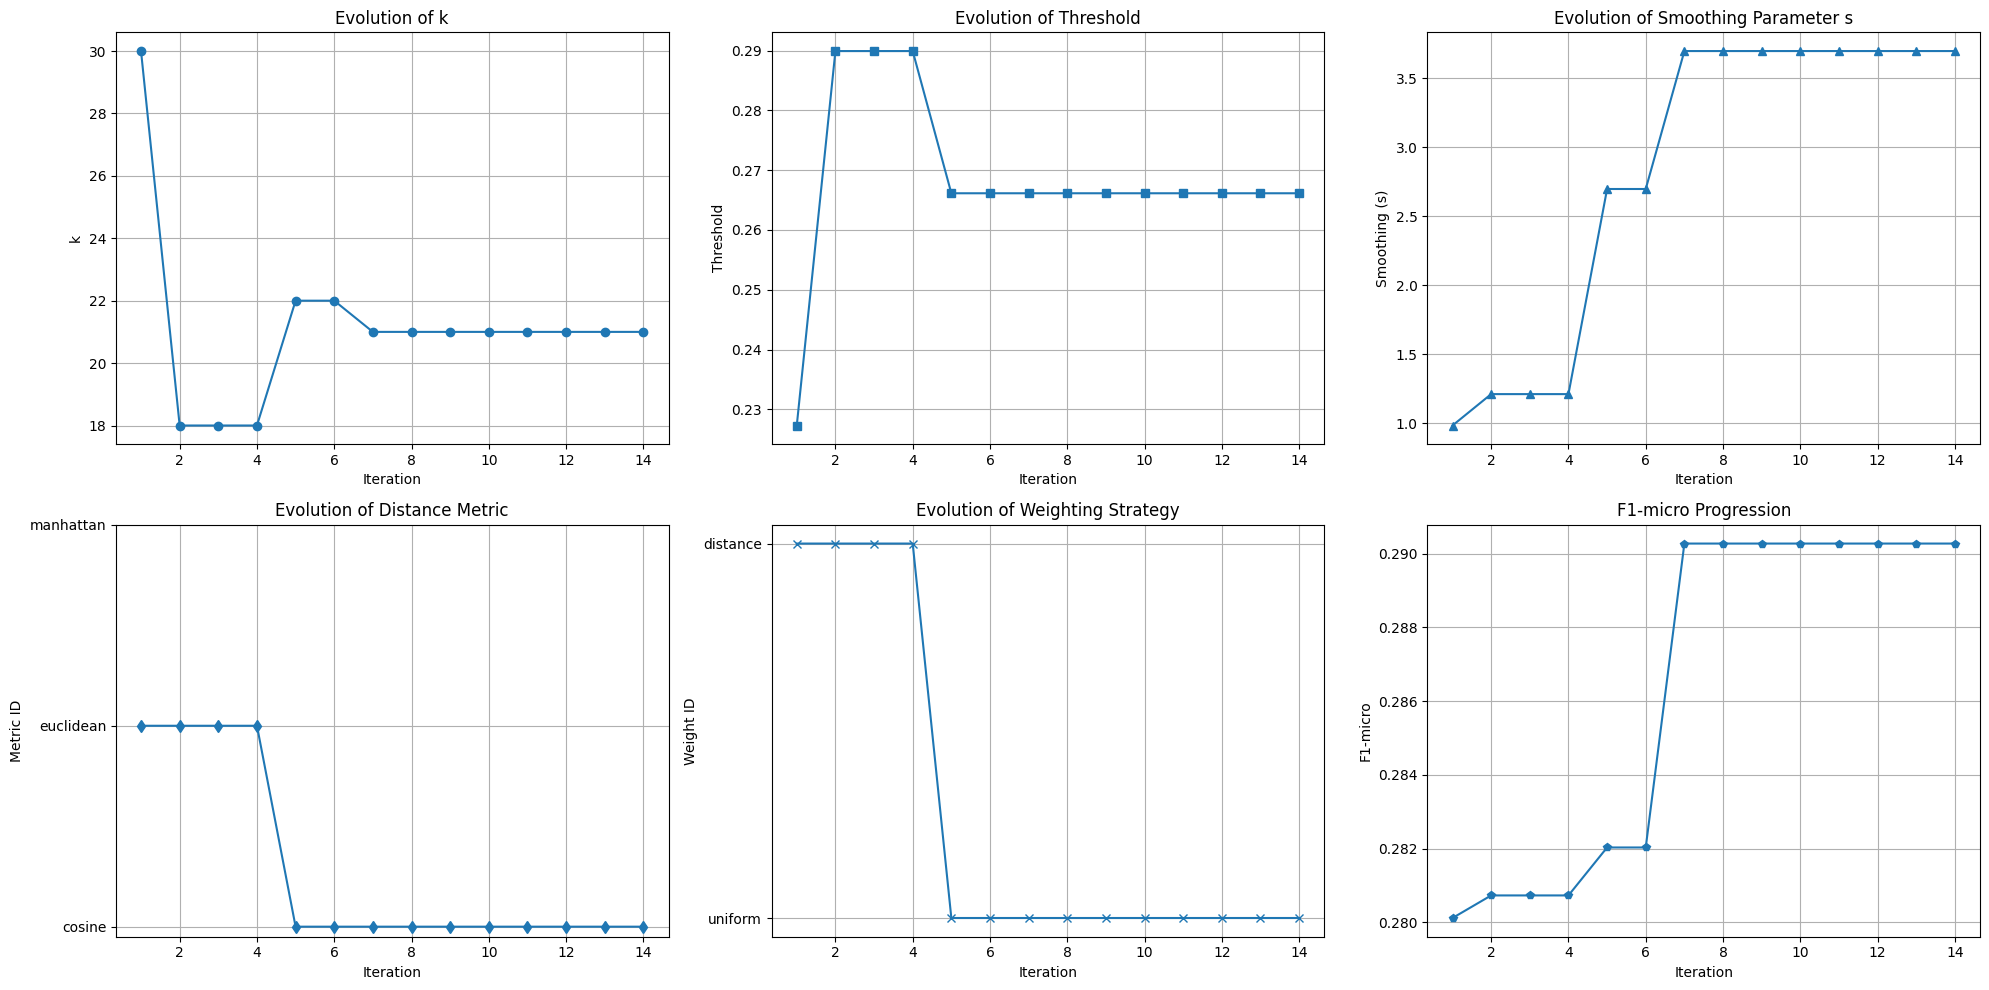

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to arrays
history_iter      = np.array(history_iter)
history_k         = np.array(history_k)
history_threshold = np.array(history_threshold)
history_s         = np.array(history_s)
history_metric    = np.array(history_metric)
history_weight    = np.array(history_weight)
history_f1micro   = np.array(history_f1micro)

plt.figure(figsize=(20, 10))

# ---- Plot 1: k ----
plt.subplot(2, 3, 1)
plt.plot(history_iter, history_k, marker='o')
plt.xlabel("Iteration")
plt.ylabel("k")
plt.title("Evolution of k")
plt.grid(True)

# ---- Plot 2: threshold ----
plt.subplot(2, 3, 2)
plt.plot(history_iter, history_threshold, marker='s')
plt.xlabel("Iteration")
plt.ylabel("Threshold")
plt.title("Evolution of Threshold")
plt.grid(True)

# ---- Plot 3: s ----
plt.subplot(2, 3, 3)
plt.plot(history_iter, history_s, marker='^')
plt.xlabel("Iteration")
plt.ylabel("Smoothing (s)")
plt.title("Evolution of Smoothing Parameter s")
plt.grid(True)

# ---- Plot 4: metric id ----
plt.subplot(2, 3, 4)
plt.plot(history_iter, history_metric, marker='d')
plt.xlabel("Iteration")
plt.ylabel("Metric ID")
plt.yticks([0, 1, 2], ['cosine', 'euclidean', 'manhattan'])
plt.title("Evolution of Distance Metric")
plt.grid(True)

# ---- Plot 5: weight id ----
plt.subplot(2, 3, 5)
plt.plot(history_iter, history_weight, marker='x')
plt.xlabel("Iteration")
plt.ylabel("Weight ID")
plt.yticks([0, 1], ['uniform', 'distance'])
plt.title("Evolution of Weighting Strategy")
plt.grid(True)

# ---- Plot 6: F1 micro ----
plt.subplot(2, 3, 6)
plt.plot(history_iter, history_f1micro, marker='p')
plt.xlabel("Iteration")
plt.ylabel("F1-micro")
plt.title("F1-micro Progression")
plt.grid(True)

plt.tight_layout()
plt.show()
